## Neural networks for segmentation

In [1]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

## Imports

In [2]:
import os
import sys
from datetime import datetime
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss

import torchvision
from torchvision import transforms

In [4]:
from tensorboardX import SummaryWriter

from ignite.engines import Trainer, Evaluator, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Metric

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

## Parameters

In [5]:
cuda = torch.cuda.is_available()
cuda_device = 0

dataset_root = './BBBC018_v1'
train_batch_size = 1
val_batch_size = 1
test_batch_size = 1
n_workers = 0

log_interval = 2
class_weights = [0.33, 1 - 0.33]

## Utils

In [6]:
def list_dir_with_full_paths(dir_path):
    dir_abs_path = os.path.abspath(dir_path)
    return sorted([os.path.join(dir_abs_path, file_name) for file_name in os.listdir(dir_abs_path)])

## Data

In [7]:
class BBBC018Dataset(Dataset):
    def __init__(self, root, mode='train', augment_fn=None):
        self.root = root
        self.mode = mode
        self.augment_fn = augment_fn
        
        self.images = self._load_images()
        if mode != 'test':
            self.masks = self._load_masks()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        image, mask = self.images[i], self.masks[i]
        if self.augment_fn is not None:
            image, mask = self.augment_fn(image, mask)
        return image, mask
    
    def _load_images(self):
        images = []
        for path in list_dir_with_full_paths(os.path.join(self.root, 'BBBC018_v1_images-fixed', self.mode)):
            image = np.array(Image.open(path))
            image = image / 255.0
            image = np.transpose(image, axes=(2, 0, 1))  # to CHW format
            images.append(image)
            
        self.image_names = os.listdir(os.path.join(self.root, 'BBBC018_v1_images-fixed', self.mode))
            
        return images
            
    def _load_masks(self):
        masks = []
        for path in list_dir_with_full_paths(os.path.join(self.root, 'BBBC018_v1_outlines', self.mode)):
            mask = np.array(Image.open(path))
            mask = (mask > 0).astype('uint8')
            mask = np.expand_dims(mask, axis=0)  # add channel dimension
            masks.append(mask)
            
        self.image_names = os.listdir(os.path.join(self.root, 'BBBC018_v1_outlines', self.mode))
            
        return masks

Augmentations:

In [8]:
# Source: https://github.com/asanakoy/kaggle_carvana_segmentation/blob/master/ternaus/src/train.py

# def grayscale_aug(image, mask):
#     car_pixels = (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * image).astype(np.uint8)

#     gray_car = cv2.cvtColor(car_pixels, cv2.COLOR_RGB2GRAY)

#     rgb_gray_car = cv2.cvtColor(gray_car, cv2.COLOR_GRAY2RGB)

#     rgb_image = image.copy()
#     rgb_image[rgb_gray_car > 0] = rgb_gray_car[rgb_gray_car > 0]
#     return rgb_image

def random_hue_saturation_value(image,
                                hue_shift_limit=(-180, 180),
                                sat_shift_limit=(-255, 255),
                                val_shift_limit=(-255, 255)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(image)
    
    hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
    h = cv2.add(h, hue_shift)
    
    sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
    s = cv2.add(s, sat_shift)
    
    val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
    v = cv2.add(v, val_shift)
    
    image = cv2.merge((h, s, v))
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def augment_fn(image, mask):
    if np.random.random() < 0.5:
        image = np.flip(image, axis=1)
        mask = np.flip(mask, axis=1)
        
    if np.random.random() < 0.5:
        image = np.flip(image, axis=2)
        mask = np.flip(mask, axis=2)

#     if np.random.random() < 0.5:
#         image = random_hue_saturation_value(image,
#                                           hue_shift_limit=(-50, 50),
#                                           sat_shift_limit=(-5, 5),
#                                           val_shift_limit=(-15, 15))

    return image.copy(), mask.copy()

## Visualization

In [9]:
def draw_images_and_masks(images, masks):
    for image, mask in zip(images, masks):
        fig, axes = plt.subplots(ncols=2)
        axes[0].imshow(np.transpose(image, axes=(1, 2, 0)))
        axes[0].set_title('image')
        axes[0].axis('off')

        axes[1].imshow(np.squeeze(mask, axis=0), cmap='gray')
        axes[1].set_title('mask')
        axes[1].axis('off')

Train:

In [10]:
train_dataset = BBBC018Dataset(dataset_root, mode='train')

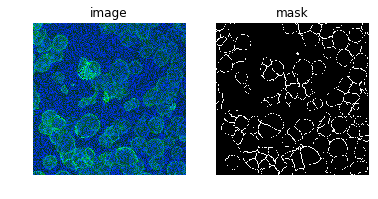

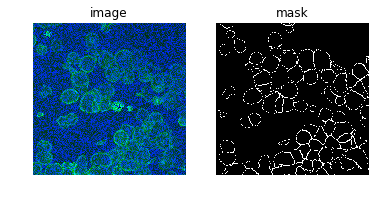

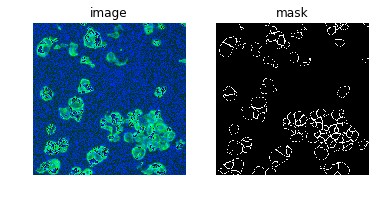

In [11]:
draw_images_and_masks(train_dataset.images[:3], train_dataset.masks[:3])

Val:

In [12]:
val_dataset = BBBC018Dataset(dataset_root, mode='val')

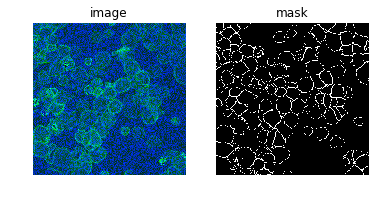

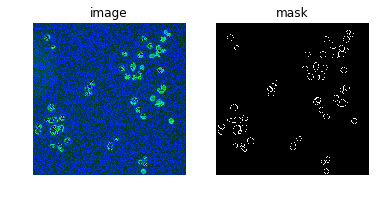

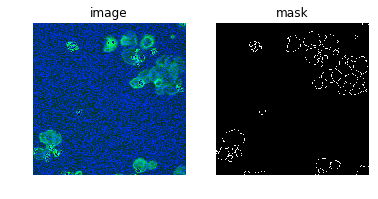

In [13]:
draw_images_and_masks(val_dataset.images[:3], val_dataset.masks[:3])

## Model

I'll use [UNet](https://arxiv.org/abs/1505.04597) for this problem.

In [14]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.relu_1 = nn.ReLU(inplace=True)
        
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.relu_2 = nn.ReLU(inplace=True)
        
        if pooling:
            self.max_pool = nn.MaxPool2d((2, 2), stride=2)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        
        x = self.conv_2(x)
        x = self.relu_2(x)
        
        x_before_pooling = x
        
        if self.pooling:
            x = self.max_pool(x)
        
        return x, x_before_pooling

In [15]:
# down_block = UnetDownBlock(3, 64, pooling=True)

# x = Variable(torch.randn(2, 3, 512, 512))
# x, x_before_pooling = down_block(x)

# print(x.shape, x_before_pooling.shape)

In [16]:
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(2, 2), stride=2)
        
        self.conv_1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)  # 2x, because of concat
        self.relu_1 = nn.ReLU(inplace=True)
        
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.relu_2 = nn.ReLU(inplace=True)
        
    def forward(self, x, x_bridge):
        x = self.conv_transpose(x)
        x = torch.cat([x, x_bridge], dim=1)
        
        x = self.conv_1(x)
        x = self.relu_1(x)
        
        x = self.conv_2(x)
        x = self.relu_2(x)
        
        return x

In [17]:
# up_block = UnetUpBlock(32, 64)

# x = Variable(torch.randn(2, 32, 10, 10))
# x_bridge = Variable(torch.randn(2, 64, 20, 20))
# x = up_block(x, x_bridge)

# print(x.shape)

In [18]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels, depth=3, base_n_filters=64):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.depth = depth
        self.base_n_filters = base_n_filters
        
        down_blocks = []
        for i in range(depth):
            current_in_channels = in_channels if i == 0 else current_out_channels
            current_out_channels = base_n_filters * (2 ** i)
            pooling = False if i == depth - 1 else True
            
            down_block = UnetDownBlock(current_in_channels, current_out_channels, pooling=pooling)
            down_blocks.append(down_block)
        
        up_blocks = []
        for i in range(depth - 1):
            current_in_channels = current_out_channels
            current_out_channels = current_in_channels // 2
            
            up_block = UnetUpBlock(current_in_channels, current_out_channels)
            up_blocks.append(up_block)
            
        self.down_blocks = nn.ModuleList(down_blocks)
        self.up_blocks = nn.ModuleList(up_blocks)
        
        self.conv_final = nn.Conv2d(current_out_channels, out_channels, kernel_size=(1, 1), stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_bridges = []
        for i in range(self.depth):
            x, x_bridge = self.down_blocks[i](x)
            if i != self.depth - 1:
                x_bridges.append(x_bridge)
        
        for i in range(self.depth - 1):
            x = self.up_blocks[i](x, x_bridges[-i - 1])
        
        x = self.conv_final(x)
        x = self.sigmoid(x)
        return x
    
    def __repr__(self):
        message = '{}(in_channels={}, out_channels={}, depth={}, base_n_filters={})'.format(
            self.__class__.__name__,
            self.in_channels, self.out_channels, self.depth, self.base_n_filters
        )
        return message

In [19]:
# unet = Unet(3, 2, depth=5)

# x = Variable(torch.randn(8, 3, 128, 128))
# x = unet(x)

# print(x.shape)

## Loss

In [20]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
        
    def forward(self, y_pred, target):
        loss = self.weights[1] * (target * torch.log(y_pred)) + self.weights[0] * ((1 - target) * torch.log(1 - y_pred))
        loss = torch.neg(torch.mean(loss))
        return loss

## Train

Dataloaders:

In [21]:
train_dataset = BBBC018Dataset(dataset_root, mode='train', augment_fn=augment_fn)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=n_workers, shuffle=True)

val_dataset = BBBC018Dataset(dataset_root, mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, num_workers=n_workers)

Model:

In [22]:
model = Unet(in_channels=3, out_channels=1, depth=6, base_n_filters=64)
if cuda:
    model = model.cuda(cuda_device)

Criterion:

In [23]:
# criterion = nn.BCELoss()
criterion = WeightedBCELoss(class_weights)
if cuda:
    criterion = criterion.cuda(cuda_device)

Optimizer:

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Tensorboard:

In [25]:
experiment_name = '{}@{}'.format(model, datetime.now().strftime("%d.%m.%Y %H:%M"))

In [26]:
tensorboard_dir = os.path.join('tb', experiment_name)
writer = SummaryWriter(tensorboard_dir)

Trainer:

In [27]:
def train_op(engine, batch):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x, y = Variable(x.type(torch.FloatTensor)), Variable(y.type(torch.FloatTensor))
    if cuda:
        x = x.cuda(cuda_device)
        y = y.cuda(cuda_device)
        
    y_pred = modeql(x)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.data.cpu()[0]

trainer = Trainer(train_op)

Metrics:

In [28]:
class BinaryCrossentropyMetric(Metric):
    def reset(self):
        self._total_value = 0
        self._n_examples = 0

    def update(self, output):
        y_pred, y = output
        y_pred, y = Variable(y_pred.type(torch.FloatTensor)), Variable(y.type(torch.FloatTensor))
        if cuda:
            y_pred = y_pred.cuda(cuda_device)
            y = y.cuda(cuda_device)
            
        self._total_value += (criterion(y_pred, y)).data.cpu()[0]
        self._n_examples += 1
        
    def compute(self):
        if self._n_examples == 0:
            raise NotComputableError('BinaryCrossentropy must have at least one example before it can be computed')
        return self._total_value / self._n_examples

In [29]:
class IOUMetric(Metric):
    def reset(self):
        self._intersection = 0
        self._union = 0

    def update(self, output):
        y_pred, y = output
        
        y_pred = (y_pred > 0.5).type(torch.FloatTensor)

        self._intersection += (y * y_pred).sum()
        self._union += ((y + y_pred) > 0).sum()

    def compute(self):
        if self._union == 0:
            raise NotComputableError('IOU must have non zero union')
        return self._intersection / self._union

In [30]:
class MeanPixelValueMetric(Metric):
    def reset(self):
        self._total_value = 0
        self._n_examples = 0

    def update(self, output):
        y_pred, y = output
        y_pred = y_pred.view(-1)
        self._total_value += torch.sum(y_pred)
        self._n_examples += y_pred.shape[0]
        
    def compute(self):
        if self._n_examples == 0:
            raise NotComputableError('MeanPixelValueMetric must have at least one example before it can be computed')
        return self._total_value / self._n_examples

Evaluator:

In [31]:
def val_op(engine, batch):
    model.eval()
    
    x, y = batch
    x, y = Variable(x.type(torch.FloatTensor), volatile=True), Variable(y.type(torch.FloatTensor), volatile=True)
    if cuda:
        x = x.cuda(cuda_device)
        y = y.cuda(cuda_device)
    
    y_pred = model(x)
    return y_pred.cpu().data, y.cpu().data

evaluator = Evaluator(val_op)

metrics = {
    'loss': BinaryCrossentropyMetric(),
    'iou': IOUMetric(),
    'mean_pixel_value': MeanPixelValueMetric()
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

Setup events:

In [32]:
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(engine.state.dataloader) + 1
    if iteration % log_interval == 0:
        print('Epoch[{}] Iteration[{}/{}] Loss: {:.4f}'.format(
            engine.state.epoch, iteration, len(engine.state.dataloader), engine.state.output
        ))
        writer.add_scalar('train/loss', engine.state.output, engine.state.iteration)

In [33]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_dataloader)
    metrics = evaluator.state.metrics
    
    print('Validation Results - Epoch: {}'.format(engine.state.epoch))
    for name, value in metrics.items():
        print(' - {} = {:.5f}'.format(name, value))
        writer.add_scalar('val/{}'.format(name), value, engine.state.epoch)
    print()

In [34]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_image_results(engine):
    x = Variable(torch.FloatTensor([val_dataset.images[0]]), volatile=True)
    if cuda:
        x = x.cuda(cuda_device)
        
    y_pred = model(x)
    writer.add_image('Image', x, engine.state.epoch)
    writer.add_image('Predicted mask', y_pred, engine.state.epoch)
    writer.add_image('Binarized mask', y_pred > 0.5, engine.state.epoch)
    writer.add_image('Groundtruth mask', torch.FloatTensor(val_dataset.masks[0]), engine.state.epoch)

In [35]:
if not os.path.exists(os.path.join('./saved_models', experiment_name)):
    os.makedirs(os.path.join('./saved_models', experiment_name))
    
best_val_loss = None

@trainer.on(Events.EPOCH_COMPLETED)
def save_best_model(engine):
    metrics = evaluator.state.metrics
    val_loss = metrics['loss']
    
    global best_val_loss
    
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss

        torch.save(model.state_dict(), os.path.join('./saved_models', experiment_name, 'best_model.pt'))
        print('New best val loss. Dumping model...')

Run training:

In [36]:
trainer.run(train_dataloader, max_epochs=400)

Epoch[1] Iteration[2/41] Loss: 0.2284
Epoch[1] Iteration[4/41] Loss: 0.2247
Epoch[1] Iteration[6/41] Loss: 0.2213
Epoch[1] Iteration[8/41] Loss: 0.2240
Epoch[1] Iteration[10/41] Loss: 0.2250
Epoch[1] Iteration[12/41] Loss: 0.2266
Epoch[1] Iteration[14/41] Loss: 0.2302
Epoch[1] Iteration[16/41] Loss: 0.2047
Epoch[1] Iteration[18/41] Loss: 0.1944
Epoch[1] Iteration[20/41] Loss: 0.1962
Epoch[1] Iteration[22/41] Loss: 0.1776
Epoch[1] Iteration[24/41] Loss: 0.1631
Epoch[1] Iteration[26/41] Loss: 0.0942
Epoch[1] Iteration[28/41] Loss: 0.1567
Epoch[1] Iteration[30/41] Loss: 0.1607
Epoch[1] Iteration[32/41] Loss: 0.0392
Epoch[1] Iteration[34/41] Loss: 0.0831
Epoch[1] Iteration[36/41] Loss: 0.1187
Epoch[1] Iteration[38/41] Loss: 0.1058
Epoch[1] Iteration[40/41] Loss: 0.0548
Validation Results - Epoch: 1
 - loss = 0.11837
 - iou = 0.00000
 - mean_pixel_value = 0.10334

New best val loss. Dumping model...
Epoch[2] Iteration[2/41] Loss: 0.1093
Epoch[2] Iteration[4/41] Loss: 0.1627
Epoch[2] Iterati

Epoch[10] Iteration[4/41] Loss: 0.0205
Epoch[10] Iteration[6/41] Loss: 0.1123
Epoch[10] Iteration[8/41] Loss: 0.0388
Epoch[10] Iteration[10/41] Loss: 0.0934
Epoch[10] Iteration[12/41] Loss: 0.0695
Epoch[10] Iteration[14/41] Loss: 0.0194
Epoch[10] Iteration[16/41] Loss: 0.1315
Epoch[10] Iteration[18/41] Loss: 0.0382
Epoch[10] Iteration[20/41] Loss: 0.0229
Epoch[10] Iteration[22/41] Loss: 0.0512
Epoch[10] Iteration[24/41] Loss: 0.0887
Epoch[10] Iteration[26/41] Loss: 0.0607
Epoch[10] Iteration[28/41] Loss: 0.1006
Epoch[10] Iteration[30/41] Loss: 0.1090
Epoch[10] Iteration[32/41] Loss: 0.0936
Epoch[10] Iteration[34/41] Loss: 0.0121
Epoch[10] Iteration[36/41] Loss: 0.0163
Epoch[10] Iteration[38/41] Loss: 0.0696
Epoch[10] Iteration[40/41] Loss: 0.0726
Validation Results - Epoch: 10
 - loss = 0.08140
 - iou = 0.00000
 - mean_pixel_value = 0.08451

New best val loss. Dumping model...
Epoch[11] Iteration[2/41] Loss: 0.0670
Epoch[11] Iteration[4/41] Loss: 0.0218
Epoch[11] Iteration[6/41] Loss: 

Epoch[19] Iteration[2/41] Loss: 0.1124
Epoch[19] Iteration[4/41] Loss: 0.0346
Epoch[19] Iteration[6/41] Loss: 0.0509
Epoch[19] Iteration[8/41] Loss: 0.0156
Epoch[19] Iteration[10/41] Loss: 0.0927
Epoch[19] Iteration[12/41] Loss: 0.0087
Epoch[19] Iteration[14/41] Loss: 0.0373
Epoch[19] Iteration[16/41] Loss: 0.1150
Epoch[19] Iteration[18/41] Loss: 0.0464
Epoch[19] Iteration[20/41] Loss: 0.0170
Epoch[19] Iteration[22/41] Loss: 0.0626
Epoch[19] Iteration[24/41] Loss: 0.0915
Epoch[19] Iteration[26/41] Loss: 0.0212
Epoch[19] Iteration[28/41] Loss: 0.0056
Epoch[19] Iteration[30/41] Loss: 0.0544
Epoch[19] Iteration[32/41] Loss: 0.1075
Epoch[19] Iteration[34/41] Loss: 0.0644
Epoch[19] Iteration[36/41] Loss: 0.0892
Epoch[19] Iteration[38/41] Loss: 0.0147
Epoch[19] Iteration[40/41] Loss: 0.0668
Validation Results - Epoch: 19
 - loss = 0.07481
 - iou = 0.14208
 - mean_pixel_value = 0.08422

New best val loss. Dumping model...
Epoch[20] Iteration[2/41] Loss: 0.1022
Epoch[20] Iteration[4/41] Loss: 

Epoch[30] Iteration[2/41] Loss: 0.0666
Epoch[30] Iteration[4/41] Loss: 0.0426
Epoch[30] Iteration[6/41] Loss: 0.0537
Epoch[30] Iteration[8/41] Loss: 0.0345
Epoch[30] Iteration[10/41] Loss: 0.0654
Epoch[30] Iteration[12/41] Loss: 0.0437
Epoch[30] Iteration[14/41] Loss: 0.0958
Epoch[30] Iteration[16/41] Loss: 0.0155
Epoch[30] Iteration[18/41] Loss: 0.0293
Epoch[30] Iteration[20/41] Loss: 0.0846
Epoch[30] Iteration[22/41] Loss: 0.1203
Epoch[30] Iteration[24/41] Loss: 0.1011
Epoch[30] Iteration[26/41] Loss: 0.0207
Epoch[30] Iteration[28/41] Loss: 0.1065
Epoch[30] Iteration[30/41] Loss: 0.0608
Epoch[30] Iteration[32/41] Loss: 0.0141
Epoch[30] Iteration[34/41] Loss: 0.0734
Epoch[30] Iteration[36/41] Loss: 0.0160
Epoch[30] Iteration[38/41] Loss: 0.0124
Epoch[30] Iteration[40/41] Loss: 0.0815
Validation Results - Epoch: 30
 - loss = 0.06929
 - iou = 0.22243
 - mean_pixel_value = 0.08277

New best val loss. Dumping model...
Epoch[31] Iteration[2/41] Loss: 0.0529
Epoch[31] Iteration[4/41] Loss: 

Epoch[39] Iteration[2/41] Loss: 0.0816
Epoch[39] Iteration[4/41] Loss: 0.0396
Epoch[39] Iteration[6/41] Loss: 0.0688
Epoch[39] Iteration[8/41] Loss: 0.0190
Epoch[39] Iteration[10/41] Loss: 0.0153
Epoch[39] Iteration[12/41] Loss: 0.0823
Epoch[39] Iteration[14/41] Loss: 0.0103
Epoch[39] Iteration[16/41] Loss: 0.0482
Epoch[39] Iteration[18/41] Loss: 0.0146
Epoch[39] Iteration[20/41] Loss: 0.0538
Epoch[39] Iteration[22/41] Loss: 0.0388
Epoch[39] Iteration[24/41] Loss: 0.0309
Epoch[39] Iteration[26/41] Loss: 0.0246
Epoch[39] Iteration[28/41] Loss: 0.0507
Epoch[39] Iteration[30/41] Loss: 0.0654
Epoch[39] Iteration[32/41] Loss: 0.0954
Epoch[39] Iteration[34/41] Loss: 0.0822
Epoch[39] Iteration[36/41] Loss: 0.0802
Epoch[39] Iteration[38/41] Loss: 0.0846
Epoch[39] Iteration[40/41] Loss: 0.0993
Validation Results - Epoch: 39
 - loss = 0.06632
 - iou = 0.23915
 - mean_pixel_value = 0.08516

New best val loss. Dumping model...
Epoch[40] Iteration[2/41] Loss: 0.0126
Epoch[40] Iteration[4/41] Loss: 

Epoch[48] Iteration[4/41] Loss: 0.1144
Epoch[48] Iteration[6/41] Loss: 0.0083
Epoch[48] Iteration[8/41] Loss: 0.0916
Epoch[48] Iteration[10/41] Loss: 0.0698
Epoch[48] Iteration[12/41] Loss: 0.0590
Epoch[48] Iteration[14/41] Loss: 0.0672
Epoch[48] Iteration[16/41] Loss: 0.0128
Epoch[48] Iteration[18/41] Loss: 0.0631
Epoch[48] Iteration[20/41] Loss: 0.0777
Epoch[48] Iteration[22/41] Loss: 0.0790
Epoch[48] Iteration[24/41] Loss: 0.0482
Epoch[48] Iteration[26/41] Loss: 0.0842
Epoch[48] Iteration[28/41] Loss: 0.0464
Epoch[48] Iteration[30/41] Loss: 0.0140
Epoch[48] Iteration[32/41] Loss: 0.0133
Epoch[48] Iteration[34/41] Loss: 0.0325
Epoch[48] Iteration[36/41] Loss: 0.0663
Epoch[48] Iteration[38/41] Loss: 0.0928
Epoch[48] Iteration[40/41] Loss: 0.0385
Validation Results - Epoch: 48
 - loss = 0.06549
 - iou = 0.25213
 - mean_pixel_value = 0.08726

New best val loss. Dumping model...
Epoch[49] Iteration[2/41] Loss: 0.0487
Epoch[49] Iteration[4/41] Loss: 0.0577
Epoch[49] Iteration[6/41] Loss: 

Epoch[57] Iteration[4/41] Loss: 0.0071
Epoch[57] Iteration[6/41] Loss: 0.0773
Epoch[57] Iteration[8/41] Loss: 0.0665
Epoch[57] Iteration[10/41] Loss: 0.0772
Epoch[57] Iteration[12/41] Loss: 0.0377
Epoch[57] Iteration[14/41] Loss: 0.0186
Epoch[57] Iteration[16/41] Loss: 0.0788
Epoch[57] Iteration[18/41] Loss: 0.0318
Epoch[57] Iteration[20/41] Loss: 0.0968
Epoch[57] Iteration[22/41] Loss: 0.0521
Epoch[57] Iteration[24/41] Loss: 0.0636
Epoch[57] Iteration[26/41] Loss: 0.0462
Epoch[57] Iteration[28/41] Loss: 0.0139
Epoch[57] Iteration[30/41] Loss: 0.0505
Epoch[57] Iteration[32/41] Loss: 0.0918
Epoch[57] Iteration[34/41] Loss: 0.0144
Epoch[57] Iteration[36/41] Loss: 0.0292
Epoch[57] Iteration[38/41] Loss: 0.0375
Epoch[57] Iteration[40/41] Loss: 0.0608
Validation Results - Epoch: 57
 - loss = 0.06562
 - iou = 0.23863
 - mean_pixel_value = 0.06777

Epoch[58] Iteration[2/41] Loss: 0.0791
Epoch[58] Iteration[4/41] Loss: 0.0362
Epoch[58] Iteration[6/41] Loss: 0.0831
Epoch[58] Iteration[8/41] Los

Epoch[66] Iteration[10/41] Loss: 0.0248
Epoch[66] Iteration[12/41] Loss: 0.0147
Epoch[66] Iteration[14/41] Loss: 0.0140
Epoch[66] Iteration[16/41] Loss: 0.0905
Epoch[66] Iteration[18/41] Loss: 0.0954
Epoch[66] Iteration[20/41] Loss: 0.0598
Epoch[66] Iteration[22/41] Loss: 0.0044
Epoch[66] Iteration[24/41] Loss: 0.0799
Epoch[66] Iteration[26/41] Loss: 0.0459
Epoch[66] Iteration[28/41] Loss: 0.0414
Epoch[66] Iteration[30/41] Loss: 0.0099
Epoch[66] Iteration[32/41] Loss: 0.0315
Epoch[66] Iteration[34/41] Loss: 0.0513
Epoch[66] Iteration[36/41] Loss: 0.0452
Epoch[66] Iteration[38/41] Loss: 0.0129
Epoch[66] Iteration[40/41] Loss: 0.0287
Validation Results - Epoch: 66
 - loss = 0.06405
 - iou = 0.26973
 - mean_pixel_value = 0.08622

Epoch[67] Iteration[2/41] Loss: 0.0168
Epoch[67] Iteration[4/41] Loss: 0.0544
Epoch[67] Iteration[6/41] Loss: 0.0511
Epoch[67] Iteration[8/41] Loss: 0.0824
Epoch[67] Iteration[10/41] Loss: 0.0776
Epoch[67] Iteration[12/41] Loss: 0.0182
Epoch[67] Iteration[14/41] 

Epoch[77] Iteration[36/41] Loss: 0.0507
Epoch[77] Iteration[38/41] Loss: 0.0172
Epoch[77] Iteration[40/41] Loss: 0.0805
Validation Results - Epoch: 77
 - loss = 0.06367
 - iou = 0.28383
 - mean_pixel_value = 0.08301

Epoch[78] Iteration[2/41] Loss: 0.0560
Epoch[78] Iteration[4/41] Loss: 0.0121
Epoch[78] Iteration[6/41] Loss: 0.0089
Epoch[78] Iteration[8/41] Loss: 0.0527
Epoch[78] Iteration[10/41] Loss: 0.0662
Epoch[78] Iteration[12/41] Loss: 0.0137
Epoch[78] Iteration[14/41] Loss: 0.0365
Epoch[78] Iteration[16/41] Loss: 0.0043
Epoch[78] Iteration[18/41] Loss: 0.0069
Epoch[78] Iteration[20/41] Loss: 0.0103
Epoch[78] Iteration[22/41] Loss: 0.0172
Epoch[78] Iteration[24/41] Loss: 0.0601
Epoch[78] Iteration[26/41] Loss: 0.0607
Epoch[78] Iteration[28/41] Loss: 0.0526
Epoch[78] Iteration[30/41] Loss: 0.0475
Epoch[78] Iteration[32/41] Loss: 0.0281
Epoch[78] Iteration[34/41] Loss: 0.0314
Epoch[78] Iteration[36/41] Loss: 0.0972
Epoch[78] Iteration[38/41] Loss: 0.0955
Epoch[78] Iteration[40/41] 

Epoch[87] Iteration[2/41] Loss: 0.0544
Epoch[87] Iteration[4/41] Loss: 0.0410
Epoch[87] Iteration[6/41] Loss: 0.0574
Epoch[87] Iteration[8/41] Loss: 0.0066
Epoch[87] Iteration[10/41] Loss: 0.0650
Epoch[87] Iteration[12/41] Loss: 0.0082
Epoch[87] Iteration[14/41] Loss: 0.0365
Epoch[87] Iteration[16/41] Loss: 0.0945
Epoch[87] Iteration[18/41] Loss: 0.0707
Epoch[87] Iteration[20/41] Loss: 0.0129
Epoch[87] Iteration[22/41] Loss: 0.0246
Epoch[87] Iteration[24/41] Loss: 0.0171
Epoch[87] Iteration[26/41] Loss: 0.1080
Epoch[87] Iteration[28/41] Loss: 0.0435
Epoch[87] Iteration[30/41] Loss: 0.0373
Epoch[87] Iteration[32/41] Loss: 0.0729
Epoch[87] Iteration[34/41] Loss: 0.0930
Epoch[87] Iteration[36/41] Loss: 0.0135
Epoch[87] Iteration[38/41] Loss: 0.0043
Epoch[87] Iteration[40/41] Loss: 0.0757
Validation Results - Epoch: 87
 - loss = 0.06335
 - iou = 0.27594
 - mean_pixel_value = 0.08162

Epoch[88] Iteration[2/41] Loss: 0.0091
Epoch[88] Iteration[4/41] Loss: 0.0136
Epoch[88] Iteration[6/41] Los

Epoch[96] Iteration[10/41] Loss: 0.0146
Epoch[96] Iteration[12/41] Loss: 0.0843
Epoch[96] Iteration[14/41] Loss: 0.0361
Epoch[96] Iteration[16/41] Loss: 0.0762
Epoch[96] Iteration[18/41] Loss: 0.0076
Epoch[96] Iteration[20/41] Loss: 0.0040
Epoch[96] Iteration[22/41] Loss: 0.0370
Epoch[96] Iteration[24/41] Loss: 0.0493
Epoch[96] Iteration[26/41] Loss: 0.0574
Epoch[96] Iteration[28/41] Loss: 0.0247
Epoch[96] Iteration[30/41] Loss: 0.0601
Epoch[96] Iteration[32/41] Loss: 0.0421
Epoch[96] Iteration[34/41] Loss: 0.0700
Epoch[96] Iteration[36/41] Loss: 0.0260
Epoch[96] Iteration[38/41] Loss: 0.0116
Epoch[96] Iteration[40/41] Loss: 0.0432
Validation Results - Epoch: 96
 - loss = 0.06556
 - iou = 0.27001
 - mean_pixel_value = 0.07341

Epoch[97] Iteration[2/41] Loss: 0.0755
Epoch[97] Iteration[4/41] Loss: 0.0353
Epoch[97] Iteration[6/41] Loss: 0.0535
Epoch[97] Iteration[8/41] Loss: 0.0065
Epoch[97] Iteration[10/41] Loss: 0.0388
Epoch[97] Iteration[12/41] Loss: 0.0339
Epoch[97] Iteration[14/41] 

Epoch[105] Iteration[14/41] Loss: 0.0553
Epoch[105] Iteration[16/41] Loss: 0.0837
Epoch[105] Iteration[18/41] Loss: 0.0075
Epoch[105] Iteration[20/41] Loss: 0.0479
Epoch[105] Iteration[22/41] Loss: 0.0512
Epoch[105] Iteration[24/41] Loss: 0.0111
Epoch[105] Iteration[26/41] Loss: 0.0669
Epoch[105] Iteration[28/41] Loss: 0.0361
Epoch[105] Iteration[30/41] Loss: 0.0224
Epoch[105] Iteration[32/41] Loss: 0.0759
Epoch[105] Iteration[34/41] Loss: 0.0145
Epoch[105] Iteration[36/41] Loss: 0.0945
Epoch[105] Iteration[38/41] Loss: 0.0153
Epoch[105] Iteration[40/41] Loss: 0.0043
Validation Results - Epoch: 105
 - loss = 0.06698
 - iou = 0.27241
 - mean_pixel_value = 0.07034

Epoch[106] Iteration[2/41] Loss: 0.0639
Epoch[106] Iteration[4/41] Loss: 0.0475
Epoch[106] Iteration[6/41] Loss: 0.0089
Epoch[106] Iteration[8/41] Loss: 0.0130
Epoch[106] Iteration[10/41] Loss: 0.0771
Epoch[106] Iteration[12/41] Loss: 0.0411
Epoch[106] Iteration[14/41] Loss: 0.0933
Epoch[106] Iteration[16/41] Loss: 0.0769
Epoc

Epoch[114] Iteration[14/41] Loss: 0.0472
Epoch[114] Iteration[16/41] Loss: 0.0521
Epoch[114] Iteration[18/41] Loss: 0.0370
Epoch[114] Iteration[20/41] Loss: 0.0124
Epoch[114] Iteration[22/41] Loss: 0.0112
Epoch[114] Iteration[24/41] Loss: 0.0836
Epoch[114] Iteration[26/41] Loss: 0.0555
Epoch[114] Iteration[28/41] Loss: 0.0181
Epoch[114] Iteration[30/41] Loss: 0.0079
Epoch[114] Iteration[32/41] Loss: 0.0141
Epoch[114] Iteration[34/41] Loss: 0.0038
Epoch[114] Iteration[36/41] Loss: 0.0225
Epoch[114] Iteration[38/41] Loss: 0.0575
Epoch[114] Iteration[40/41] Loss: 0.0696
Validation Results - Epoch: 114
 - loss = 0.06732
 - iou = 0.27915
 - mean_pixel_value = 0.07295

Epoch[115] Iteration[2/41] Loss: 0.0507
Epoch[115] Iteration[4/41] Loss: 0.0324
Epoch[115] Iteration[6/41] Loss: 0.0474
Epoch[115] Iteration[8/41] Loss: 0.0081
Epoch[115] Iteration[10/41] Loss: 0.0475
Epoch[115] Iteration[12/41] Loss: 0.0712
Epoch[115] Iteration[14/41] Loss: 0.0092
Epoch[115] Iteration[16/41] Loss: 0.0818
Epoc

Epoch[123] Iteration[14/41] Loss: 0.0875
Epoch[123] Iteration[16/41] Loss: 0.0086
Epoch[123] Iteration[18/41] Loss: 0.1006
Epoch[123] Iteration[20/41] Loss: 0.0512
Epoch[123] Iteration[22/41] Loss: 0.0601
Epoch[123] Iteration[24/41] Loss: 0.0420
Epoch[123] Iteration[26/41] Loss: 0.0124
Epoch[123] Iteration[28/41] Loss: 0.0448
Epoch[123] Iteration[30/41] Loss: 0.0661
Epoch[123] Iteration[32/41] Loss: 0.0520
Epoch[123] Iteration[34/41] Loss: 0.0417
Epoch[123] Iteration[36/41] Loss: 0.0320
Epoch[123] Iteration[38/41] Loss: 0.0372
Epoch[123] Iteration[40/41] Loss: 0.0379
Validation Results - Epoch: 123
 - loss = 0.07632
 - iou = 0.27765
 - mean_pixel_value = 0.07039

Epoch[124] Iteration[2/41] Loss: 0.0716
Epoch[124] Iteration[4/41] Loss: 0.0453
Epoch[124] Iteration[6/41] Loss: 0.0172
Epoch[124] Iteration[8/41] Loss: 0.0828
Epoch[124] Iteration[10/41] Loss: 0.0077
Epoch[124] Iteration[12/41] Loss: 0.0131
Epoch[124] Iteration[14/41] Loss: 0.0467
Epoch[124] Iteration[16/41] Loss: 0.0124
Epoc

Epoch[132] Iteration[14/41] Loss: 0.0686
Epoch[132] Iteration[16/41] Loss: 0.0579
Epoch[132] Iteration[18/41] Loss: 0.0310
Epoch[132] Iteration[20/41] Loss: 0.0357
Epoch[132] Iteration[22/41] Loss: 0.0389
Epoch[132] Iteration[24/41] Loss: 0.0035
Epoch[132] Iteration[26/41] Loss: 0.0274
Epoch[132] Iteration[28/41] Loss: 0.0129
Epoch[132] Iteration[30/41] Loss: 0.0676
Epoch[132] Iteration[32/41] Loss: 0.0311
Epoch[132] Iteration[34/41] Loss: 0.0782
Epoch[132] Iteration[36/41] Loss: 0.0065
Epoch[132] Iteration[38/41] Loss: 0.0597
Epoch[132] Iteration[40/41] Loss: 0.0122
Validation Results - Epoch: 132
 - loss = 0.07488
 - iou = 0.28349
 - mean_pixel_value = 0.08066

Epoch[133] Iteration[2/41] Loss: 0.0429
Epoch[133] Iteration[4/41] Loss: 0.0097
Epoch[133] Iteration[6/41] Loss: 0.0120
Epoch[133] Iteration[8/41] Loss: 0.0136
Epoch[133] Iteration[10/41] Loss: 0.0882
Epoch[133] Iteration[12/41] Loss: 0.0759
Epoch[133] Iteration[14/41] Loss: 0.0813
Epoch[133] Iteration[16/41] Loss: 0.0351
Epoc

Epoch[141] Iteration[14/41] Loss: 0.0080
Epoch[141] Iteration[16/41] Loss: 0.0389
Epoch[141] Iteration[18/41] Loss: 0.0168
Epoch[141] Iteration[20/41] Loss: 0.0467
Epoch[141] Iteration[22/41] Loss: 0.0863
Epoch[141] Iteration[24/41] Loss: 0.0107
Epoch[141] Iteration[26/41] Loss: 0.0295
Epoch[141] Iteration[28/41] Loss: 0.0103
Epoch[141] Iteration[30/41] Loss: 0.0441
Epoch[141] Iteration[32/41] Loss: 0.0418
Epoch[141] Iteration[34/41] Loss: 0.0032
Epoch[141] Iteration[36/41] Loss: 0.0373
Epoch[141] Iteration[38/41] Loss: 0.0844
Epoch[141] Iteration[40/41] Loss: 0.0284
Validation Results - Epoch: 141
 - loss = 0.07906
 - iou = 0.27510
 - mean_pixel_value = 0.07312

Epoch[142] Iteration[2/41] Loss: 0.0175
Epoch[142] Iteration[4/41] Loss: 0.0480
Epoch[142] Iteration[6/41] Loss: 0.0286
Epoch[142] Iteration[8/41] Loss: 0.0601
Epoch[142] Iteration[10/41] Loss: 0.0747
Epoch[142] Iteration[12/41] Loss: 0.0066
Epoch[142] Iteration[14/41] Loss: 0.0293
Epoch[142] Iteration[16/41] Loss: 0.0103
Epoc

Epoch[150] Iteration[14/41] Loss: 0.0111
Epoch[150] Iteration[16/41] Loss: 0.0728
Epoch[150] Iteration[18/41] Loss: 0.0704
Epoch[150] Iteration[20/41] Loss: 0.0091
Epoch[150] Iteration[22/41] Loss: 0.0645
Epoch[150] Iteration[24/41] Loss: 0.0036
Epoch[150] Iteration[26/41] Loss: 0.0311
Epoch[150] Iteration[28/41] Loss: 0.0589
Epoch[150] Iteration[30/41] Loss: 0.0331
Epoch[150] Iteration[32/41] Loss: 0.0819
Epoch[150] Iteration[34/41] Loss: 0.0494
Epoch[150] Iteration[36/41] Loss: 0.0536
Epoch[150] Iteration[38/41] Loss: 0.0241
Epoch[150] Iteration[40/41] Loss: 0.0356
Validation Results - Epoch: 150
 - loss = 0.09153
 - iou = 0.27000
 - mean_pixel_value = 0.07182

Epoch[151] Iteration[2/41] Loss: 0.0238
Epoch[151] Iteration[4/41] Loss: 0.0795
Epoch[151] Iteration[6/41] Loss: 0.0103
Epoch[151] Iteration[8/41] Loss: 0.0117
Epoch[151] Iteration[10/41] Loss: 0.0613
Epoch[151] Iteration[12/41] Loss: 0.0116
Epoch[151] Iteration[14/41] Loss: 0.0168
Epoch[151] Iteration[16/41] Loss: 0.0316
Epoc

Epoch[159] Iteration[14/41] Loss: 0.0054
Epoch[159] Iteration[16/41] Loss: 0.0630
Epoch[159] Iteration[18/41] Loss: 0.0067
Epoch[159] Iteration[20/41] Loss: 0.0085
Epoch[159] Iteration[22/41] Loss: 0.0146
Epoch[159] Iteration[24/41] Loss: 0.0540
Epoch[159] Iteration[26/41] Loss: 0.0237
Epoch[159] Iteration[28/41] Loss: 0.0065
Epoch[159] Iteration[30/41] Loss: 0.0401
Epoch[159] Iteration[32/41] Loss: 0.0029
Epoch[159] Iteration[34/41] Loss: 0.0345
Epoch[159] Iteration[36/41] Loss: 0.0497
Epoch[159] Iteration[38/41] Loss: 0.0328
Epoch[159] Iteration[40/41] Loss: 0.0060
Validation Results - Epoch: 159
 - loss = 0.10160
 - iou = 0.26170
 - mean_pixel_value = 0.06362

Epoch[160] Iteration[2/41] Loss: 0.0654
Epoch[160] Iteration[4/41] Loss: 0.0112
Epoch[160] Iteration[6/41] Loss: 0.0346
Epoch[160] Iteration[8/41] Loss: 0.0159
Epoch[160] Iteration[10/41] Loss: 0.0168
Epoch[160] Iteration[12/41] Loss: 0.0805
Epoch[160] Iteration[14/41] Loss: 0.0732
Epoch[160] Iteration[16/41] Loss: 0.0251
Epoc

Epoch[168] Iteration[14/41] Loss: 0.0706
Epoch[168] Iteration[16/41] Loss: 0.0261
Epoch[168] Iteration[18/41] Loss: 0.0351
Epoch[168] Iteration[20/41] Loss: 0.0345
Epoch[168] Iteration[22/41] Loss: 0.0341
Epoch[168] Iteration[24/41] Loss: 0.0295
Epoch[168] Iteration[26/41] Loss: 0.0231
Epoch[168] Iteration[28/41] Loss: 0.0289
Epoch[168] Iteration[30/41] Loss: 0.0059
Epoch[168] Iteration[32/41] Loss: 0.0125
Epoch[168] Iteration[34/41] Loss: 0.0726
Epoch[168] Iteration[36/41] Loss: 0.0109
Epoch[168] Iteration[38/41] Loss: 0.0133
Epoch[168] Iteration[40/41] Loss: 0.0319
Validation Results - Epoch: 168
 - loss = 0.09894
 - iou = 0.26379
 - mean_pixel_value = 0.07067

Epoch[169] Iteration[2/41] Loss: 0.0111
Epoch[169] Iteration[4/41] Loss: 0.0064
Epoch[169] Iteration[6/41] Loss: 0.0499
Epoch[169] Iteration[8/41] Loss: 0.0625
Epoch[169] Iteration[10/41] Loss: 0.0362
Epoch[169] Iteration[12/41] Loss: 0.0084
Epoch[169] Iteration[14/41] Loss: 0.0098
Epoch[169] Iteration[16/41] Loss: 0.0301
Epoc

Epoch[177] Iteration[14/41] Loss: 0.0246
Epoch[177] Iteration[16/41] Loss: 0.0534
Epoch[177] Iteration[18/41] Loss: 0.0280
Epoch[177] Iteration[20/41] Loss: 0.0484
Epoch[177] Iteration[22/41] Loss: 0.0343
Epoch[177] Iteration[24/41] Loss: 0.0089
Epoch[177] Iteration[26/41] Loss: 0.0220
Epoch[177] Iteration[28/41] Loss: 0.0605
Epoch[177] Iteration[30/41] Loss: 0.0343
Epoch[177] Iteration[32/41] Loss: 0.0213
Epoch[177] Iteration[34/41] Loss: 0.0651
Epoch[177] Iteration[36/41] Loss: 0.0158
Epoch[177] Iteration[38/41] Loss: 0.0329
Epoch[177] Iteration[40/41] Loss: 0.0081
Validation Results - Epoch: 177
 - loss = 0.09996
 - iou = 0.26151
 - mean_pixel_value = 0.07086

Epoch[178] Iteration[2/41] Loss: 0.0125
Epoch[178] Iteration[4/41] Loss: 0.0210
Epoch[178] Iteration[6/41] Loss: 0.0140
Epoch[178] Iteration[8/41] Loss: 0.0388
Epoch[178] Iteration[10/41] Loss: 0.0531
Epoch[178] Iteration[12/41] Loss: 0.0275
Epoch[178] Iteration[14/41] Loss: 0.0029
Epoch[178] Iteration[16/41] Loss: 0.0335
Epoc

Epoch[186] Iteration[14/41] Loss: 0.0184
Epoch[186] Iteration[16/41] Loss: 0.0075
Epoch[186] Iteration[18/41] Loss: 0.0048
Epoch[186] Iteration[20/41] Loss: 0.0584
Epoch[186] Iteration[22/41] Loss: 0.0098
Epoch[186] Iteration[24/41] Loss: 0.0113
Epoch[186] Iteration[26/41] Loss: 0.0448
Epoch[186] Iteration[28/41] Loss: 0.0203
Epoch[186] Iteration[30/41] Loss: 0.0313
Epoch[186] Iteration[32/41] Loss: 0.0069
Epoch[186] Iteration[34/41] Loss: 0.0300
Epoch[186] Iteration[36/41] Loss: 0.0055
Epoch[186] Iteration[38/41] Loss: 0.0051
Epoch[186] Iteration[40/41] Loss: 0.0331
Validation Results - Epoch: 186
 - loss = 0.12928
 - iou = 0.25532
 - mean_pixel_value = 0.06051

Epoch[187] Iteration[2/41] Loss: 0.0308
Epoch[187] Iteration[4/41] Loss: 0.0199
Epoch[187] Iteration[6/41] Loss: 0.0051
Epoch[187] Iteration[8/41] Loss: 0.0271
Epoch[187] Iteration[10/41] Loss: 0.0054
Epoch[187] Iteration[12/41] Loss: 0.0659
Epoch[187] Iteration[14/41] Loss: 0.0298
Epoch[187] Iteration[16/41] Loss: 0.0097
Epoc

Epoch[195] Iteration[14/41] Loss: 0.0125
Epoch[195] Iteration[16/41] Loss: 0.0080
Epoch[195] Iteration[18/41] Loss: 0.0212
Epoch[195] Iteration[20/41] Loss: 0.0174
Epoch[195] Iteration[22/41] Loss: 0.0267
Epoch[195] Iteration[24/41] Loss: 0.0051
Epoch[195] Iteration[26/41] Loss: 0.0603
Epoch[195] Iteration[28/41] Loss: 0.0283
Epoch[195] Iteration[30/41] Loss: 0.0232
Epoch[195] Iteration[32/41] Loss: 0.0616
Epoch[195] Iteration[34/41] Loss: 0.0117
Epoch[195] Iteration[36/41] Loss: 0.0117
Epoch[195] Iteration[38/41] Loss: 0.0249
Epoch[195] Iteration[40/41] Loss: 0.0494
Validation Results - Epoch: 195
 - loss = 0.11699
 - iou = 0.26058
 - mean_pixel_value = 0.07066

Epoch[196] Iteration[2/41] Loss: 0.0609
Epoch[196] Iteration[4/41] Loss: 0.0047
Epoch[196] Iteration[6/41] Loss: 0.0185
Epoch[196] Iteration[8/41] Loss: 0.0047
Epoch[196] Iteration[10/41] Loss: 0.0298
Epoch[196] Iteration[12/41] Loss: 0.0480
Epoch[196] Iteration[14/41] Loss: 0.0289
Epoch[196] Iteration[16/41] Loss: 0.0338
Epoc

Epoch[204] Iteration[14/41] Loss: 0.0243
Epoch[204] Iteration[16/41] Loss: 0.0287
Epoch[204] Iteration[18/41] Loss: 0.0181
Epoch[204] Iteration[20/41] Loss: 0.0350
Epoch[204] Iteration[22/41] Loss: 0.0025
Epoch[204] Iteration[24/41] Loss: 0.0116
Epoch[204] Iteration[26/41] Loss: 0.0055
Epoch[204] Iteration[28/41] Loss: 0.0442
Epoch[204] Iteration[30/41] Loss: 0.0200
Epoch[204] Iteration[32/41] Loss: 0.0286
Epoch[204] Iteration[34/41] Loss: 0.0155
Epoch[204] Iteration[36/41] Loss: 0.0260
Epoch[204] Iteration[38/41] Loss: 0.0573
Epoch[204] Iteration[40/41] Loss: 0.0083
Validation Results - Epoch: 204
 - loss = 0.12558
 - iou = 0.24947
 - mean_pixel_value = 0.06572

Epoch[205] Iteration[2/41] Loss: 0.0087
Epoch[205] Iteration[4/41] Loss: 0.0087
Epoch[205] Iteration[6/41] Loss: 0.0037
Epoch[205] Iteration[8/41] Loss: 0.0262
Epoch[205] Iteration[10/41] Loss: 0.0378
Epoch[205] Iteration[12/41] Loss: 0.0273
Epoch[205] Iteration[14/41] Loss: 0.0240
Epoch[205] Iteration[16/41] Loss: 0.0402
Epoc

Epoch[213] Iteration[14/41] Loss: nan
Epoch[213] Iteration[16/41] Loss: nan
Epoch[213] Iteration[18/41] Loss: nan
Epoch[213] Iteration[20/41] Loss: nan


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch[385] Iteration[28/41] Loss: nan
Epoch[385] Iteration[30/41] Loss: nan
Epoch[385] Iteration[32/41] Loss: nan
Epoch[385] Iteration[34/41] Loss: nan
Epoch[385] Iteration[36/41] Loss: nan
Epoch[385] Iteration[38/41] Loss: nan
Epoch[385] Iteration[40/41] Loss: nan
Validation Results - Epoch: 385
 - loss = nan
 - iou = 0.00000
 - mean_pixel_value = nan

Epoch[386] Iteration[2/41] Loss: nan
Epoch[386] Iteration[4/41] Loss: nan
Epoch[386] Iteration[6/41] Loss: nan
Epoch[386] Iteration[8/41] Loss: nan
Epoch[386] Iteration[10/41] Loss: nan
Epoch[386] Iteration[12/41] Loss: nan
Epoch[386] Iteration[14/41] Loss: nan
Epoch[386] Iteration[16/41] Loss: nan
Epoch[386] Iteration[18/41] Loss: nan
Epoch[386] Iteration[20/41] Loss: nan
Epoch[386] Iteration[22/41] Loss: nan
Epoch[386] Iteration[24/41] Loss: nan
Epoch[386] Iteration[26/41] Loss: nan
Epoch[386] Iteration[28/41] Loss: nan
Epoch[386] Iteration[30/41] Loss: nan
Epoch[386] Iteration[32/41] Loss: nan
Epoch[386] Iteration[34/41] Loss: nan
Ep

Epoch[395] Iteration[14/41] Loss: nan
Epoch[395] Iteration[16/41] Loss: nan
Epoch[395] Iteration[18/41] Loss: nan
Epoch[395] Iteration[20/41] Loss: nan
Epoch[395] Iteration[22/41] Loss: nan
Epoch[395] Iteration[24/41] Loss: nan
Epoch[395] Iteration[26/41] Loss: nan
Epoch[395] Iteration[28/41] Loss: nan
Epoch[395] Iteration[30/41] Loss: nan
Epoch[395] Iteration[32/41] Loss: nan
Epoch[395] Iteration[34/41] Loss: nan
Epoch[395] Iteration[36/41] Loss: nan
Epoch[395] Iteration[38/41] Loss: nan
Epoch[395] Iteration[40/41] Loss: nan
Validation Results - Epoch: 395
 - loss = nan
 - iou = 0.00000
 - mean_pixel_value = nan

Epoch[396] Iteration[2/41] Loss: nan
Epoch[396] Iteration[4/41] Loss: nan
Epoch[396] Iteration[6/41] Loss: nan
Epoch[396] Iteration[8/41] Loss: nan
Epoch[396] Iteration[10/41] Loss: nan
Epoch[396] Iteration[12/41] Loss: nan
Epoch[396] Iteration[14/41] Loss: nan
Epoch[396] Iteration[16/41] Loss: nan
Epoch[396] Iteration[18/41] Loss: nan
Epoch[396] Iteration[20/41] Loss: nan
Ep

## Submit results

In [37]:
saved_models_dirs = sorted(list_dir_with_full_paths('./saved_models/'), key=lambda x: os.path.getmtime(x), reverse=True)
best_model_path = os.path.join(saved_models_dirs[0], 'best_model.pt')

In [38]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

Unet(in_channels=3, out_channels=1, depth=6, base_n_filters=64)

In [39]:
test_dataset = BBBC018Dataset(dataset_root, mode='test')

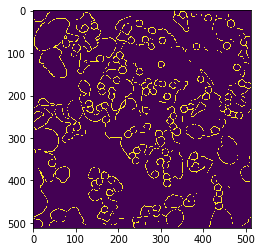

In [40]:
if not os.path.exists(os.path.join('./results', experiment_name)):
    os.makedirs(os.path.join('./results', experiment_name))

masks = []
for x, name in zip(test_dataset.images, test_dataset.image_names):
    x = Variable(torch.FloatTensor([x]), volatile=True)
    if cuda:
        x = x.cuda(cuda_device)
    
    y_pred = model(x) > 0.5
    plt.imshow(y_pred.cpu().data.numpy()[0][0])
    
    image = Image.fromarray(y_pred.cpu().data.numpy()[0][0] * 255)
    image.save(os.path.join('./results', experiment_name, name.replace('.bmp', '.png')))

## Records

I read [this](https://arxiv.org/abs/1505.04597) paper about UNet. Originally it was used for segmentation in medicine. So I decided to use it. I found some implementations of UNet on GitHub and using them as a baseline code — created my own implementation of UNet.

I managed to conduct 4 experiments in 2 dimensions (UNet depth and class weights):
- UNet(depth=5) and class_weights=[1, 1].Val IOU: 0.279
- UNet(depth=5) and class_weights=[0.33, 1 - 0.33]. Val IOU: 0.281
- UNet(depth=6) and class_weights=[1, 1]. Val IOU: 0.288
- UNet(depth=6) and class_weights=[0.33, 1 - 0.33]. **Val IOU: 0.289**

Things I didn't managed to try:
- dice loss
- selecting threshold for binarization, not only 0.5
- color augmentations
- lr decay
- TTA
- CRF
- using not UNet, but PSPNet or other nets